# Rate estimation

From the ten 1 µs-long traces at each epsilon value (snapshots every 100 ps), we can make rough estimates of the binding and unbinding rates, using our four-state model:

$ B \leftrightarrow EC1 \leftrightarrow EC2 \leftrightarrow U $

where $B$ is the bound state, $EC1$ and $EC2$ are encounter complexes, and $U$ is the unbound state.  

* $EC1$ is near 3.8 nm, near the entrance to the entrance to the binding site
* $EC2$ is around 6.25 nm, which corresponds to the ligand adhering the the trangular wall fo the binding pocket.

In the `free_energies.ipynb` notebook, we manually chose 1D dividing surfaces to separate these states: 0.25 nm, 0.525 nm, and 0.85 nm to build a crude 4-state kinetic model for the purpose of estimating rates.  

**Note:**  projection to a single reaction coordinate, and the arbitrary choice of state discretaton here will artifically accelerate the rates estimates. That is fine for now, because we just want to get rough estimates of the binding rates in order to chooseg good parameters for our test system.  Later, we will do a much more thorough calculation to estimate rates and binding free energies, using multi-ensemble estimators.



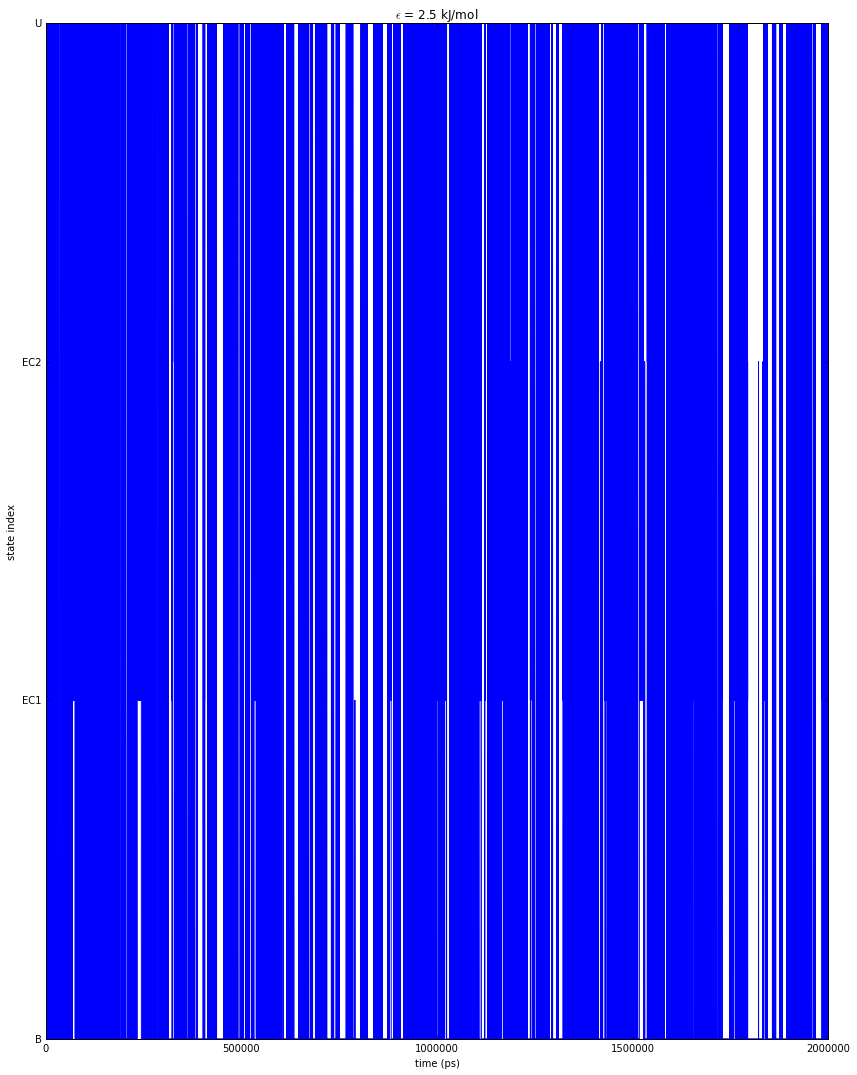

In [3]:
import sys, os
import numpy as np

### Read in the distance trajectory data ###

# As before, we're only going to look at a limited set of epsilon values,
#     because for eps < 0.5 kJ/mol binidng/unbinding is too fast
#     and for eps > 3.5 kJ/mol binidng/unbinding is too SLOW!

epsilons = [2.5]
neps = len(epsilons)
ntrials = 20    # there are 20 parallel trajectories
nsnaps = 2000001  # 2 us of simulation with snapshots every 1 ps

# load all the distance data
distances = np.zeros( (neps, ntrials, nsnaps) )
maxsnaps = np.zeros( (neps, ntrials), dtype=int )  # keep track of how many snapshots in each trajectory, for anlaysis
for i in range(neps):
    for j in range(ntrials):
        infile = 'distance_%d.npy'%(j)
        maxsnaps[i,j] = np.load(infile).shape[0]
        if maxsnaps[i,j] < nsnaps:
            print 'WARNING:', infile, 'has only %d < %d snapshots'%(maxsnaps[i,j],nsnaps)
        distances[i,j,0:maxsnaps[i,j]] = np.load(infile)

### next we digitize the trajectory data into state indices ###
dividing_surfaces = [0.25, 0.525, 0.85] # in nm
states = np.digitize(distances, bins=dividing_surfaces)

# let's plot some example traces
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure( figsize=(12,15))
panel = 1
time_in_ns = np.arange(0, 2000001,1 ) # time in ps
j = 0 # pick just trial 0
for i in range(neps):
    plt.subplot(neps, 1, panel)
    panel += 1   
    plt.plot(time_in_ns[0:maxsnaps[i,j]], states[i,j,0:maxsnaps[i,j]])
    plt.title('$\epsilon$ = %1.1f kJ/mol'%(epsilons[i]))
    plt.xlabel('time (ps)')
    plt.ylabel('state index')
    plt.yticks([0,1,2,3], ['B','EC1','EC2','U'])
plt.tight_layout()
plt.show()






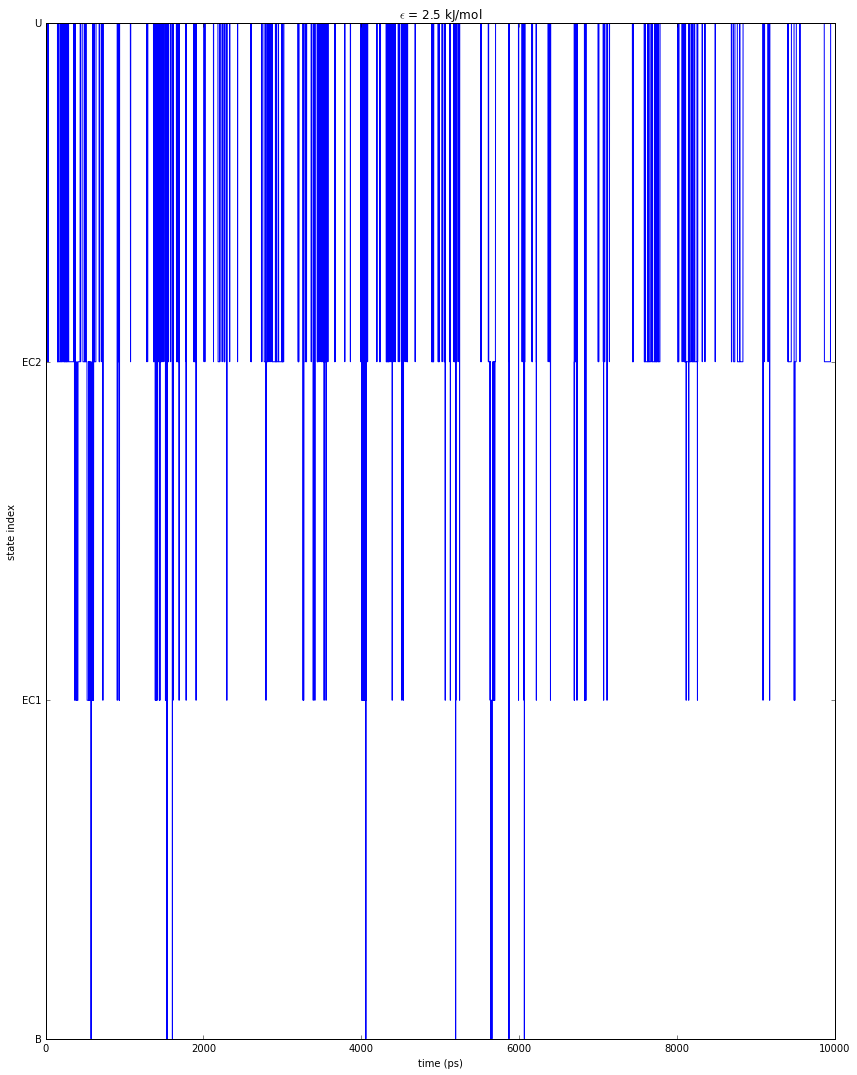

In [4]:
# let's zoom in on the first 100 ns some example traces
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure( figsize=(12,15))
panel = 1
time_in_ns = np.arange(0, 2000001, 1) # time in ps
j = 0 # pick just trial 0
showmaxsnaps = 10000
for i in range(neps):
    plt.subplot(neps, 1, panel)
    panel += 1   
    plt.plot(time_in_ns[0:showmaxsnaps], states[i,j,0:showmaxsnaps])
    plt.title('$\epsilon$ = %1.1f kJ/mol'%(epsilons[i]))
    plt.xlabel('time (ps)')
    plt.ylabel('state index')
    plt.yticks([0,1,2,3], ['B','EC1','EC2','U'])
plt.tight_layout()
plt.show()





In [6]:
# Next, we construct 4-state MSMs for each value of epsilon

# We need to write some functions that we can reuse

def state_trajectories_to_counts(straj, maxsnaps, n, lag=1):
    """
    Returns a count matrix given an array of state indices with values 0,...,n-1 
    
    INPUTS
        straj    - a np.array of size (ntrials, nframes)
        maxsnaps - np.array of size (ntrials,) storing the trajlength for each trial
        n        - the total number of state indices (0, ... , n-1)
    
    PARAMETERS
        lag      - the lag time in number of frames (Default 1 frame)
    
    RETURNS
        counts   - an (n,n) count matrix with number of transitions from
                  state i to j stored in elements C[i,j]
    """
    
    counts = np.zeros( (n,n) )
    ntrials = straj.shape[0]
    for trial in range(ntrials):
        for frame in range(0,(maxsnaps[trial]-lag)):
            i,j = straj[trial,frame], straj[trial,frame+lag]
            counts[i,j] += 1.0
    return counts

for i in range(neps):
    print 'epsilon = %1,1f counts:', epsilons[i]
    counts = state_trajectories_to_counts(states[i], maxsnaps[i], 4, lag=1)
    print counts

epsilon = %1,1f counts: 2.5
[[ 26682549.     50284.     82710.    709466.]
 [    50683.    232006.     98548.    100734.]
 [    82827.     98294.    743834.    412938.]
 [   708960.    101387.    412802.   9431978.]]


In [7]:
# let's compute how many binding and unbinding events happened and the dwell time
# 0 --> bound state, 1 --> unbound state
ns_per_frame = 0.001   # frames were saved every 1ps
total_binding = []
total_unbinding = []
times_binding = []
times_unbinding = []
for i in range(20):
    print i
    dis = total_converted[i]
    unbinding = np.where(np.diff(dis)>0.5)[0]+1
    binding = np.where(np.diff(dis)<-0.5)[0]+1
    #print bound
    #print unbound
    times_binding.append(len(binding))
    times_unbinding.append(len(unbinding))
    dwell_binding = []
    dwell_unbinding = []
    dwell_binding.append(binding[0]*ns_per_frame)
    # since the first event is binding for sure so the number of unbinding events cannot be more than the number of binding events
    if len(binding) != len(unbinding):
        for j in range(len(unbinding)):
            dwell_binding.append((binding[1:][j]-unbinding[j])*ns_per_frame)
            dwell_unbinding.append((unbinding[j]-binding[j])*ns_per_frame)
    else:
        for j in range(len(unbinding)):
            dwell_unbinding.append((unbinding[j]-binding[j])*ns_per_frame)
        for j in range(len(binding)-1):
            dwell_binding.append((binding[1:][j]-unbinding[j])*ns_per_frame)
    print dwell_binding
    print dwell_unbinding
    total_binding.append(dwell_binding)
    total_unbinding.append(dwell_unbinding)
np.save('total_binding_dwell.npy',total_binding)
np.save('total_unbinding_dwell.npy',total_unbinding)
print "Done!"

0


NameError: name 'total_converted' is not defined

Binding events dwell time distribution
longest dwell time 4.3 ns
longest dwell time 3.6 ns
longest dwell time 3.9 ns
longest dwell time 3.4 ns
longest dwell time 2.9 ns
longest dwell time 3.9 ns
longest dwell time 3.2 ns
longest dwell time 4.3 ns
longest dwell time 3.3 ns
longest dwell time 3.5 ns
longest dwell time 4.1 ns
longest dwell time 3.6 ns
longest dwell time 4.4 ns
longest dwell time 4.0 ns
longest dwell time 3.2 ns
longest dwell time 4.0 ns
longest dwell time 4.6 ns
longest dwell time 3.9 ns
longest dwell time 4.1 ns
longest dwell time 4.0 ns


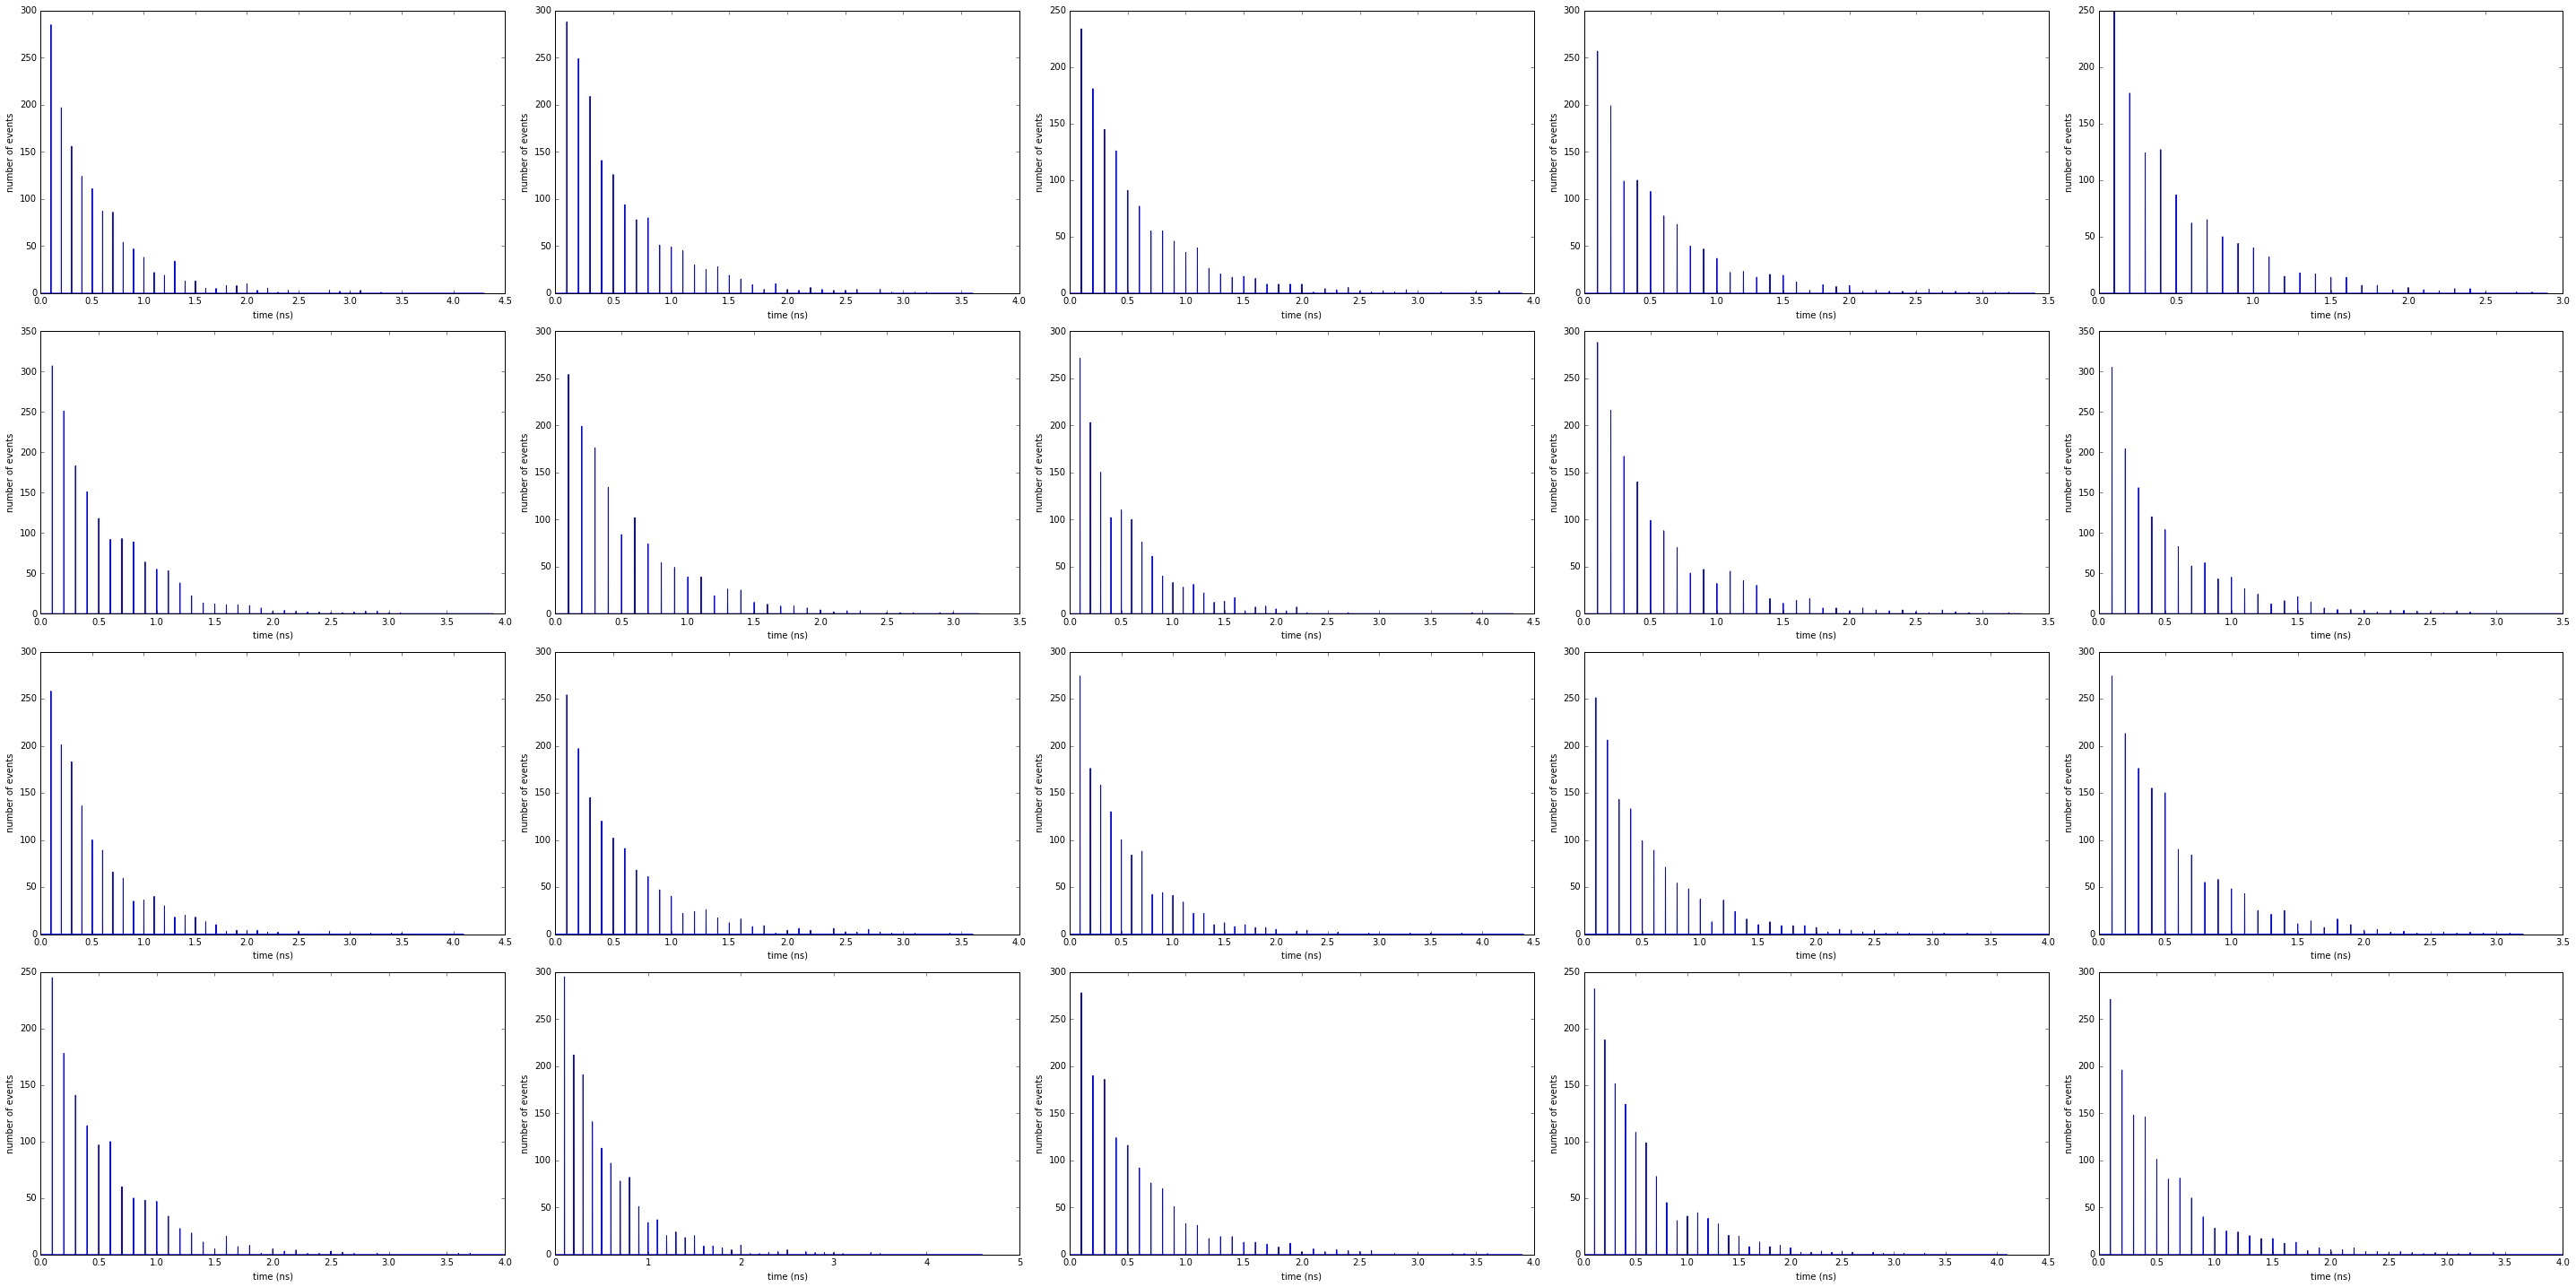

Unbinding events dwell time distribution
longest dwell time 176.9 ns
longest dwell time 126.4 ns
longest dwell time 129.1 ns
longest dwell time 108.8 ns
longest dwell time 117.1 ns
longest dwell time 110.1 ns
longest dwell time 127.8 ns
longest dwell time 127.1 ns
longest dwell time 100.9 ns
longest dwell time 125.8 ns
longest dwell time 128.8 ns
longest dwell time 140.6 ns
longest dwell time 121.5 ns
longest dwell time 140.0 ns
longest dwell time 156.8 ns
longest dwell time 132.1 ns
longest dwell time 152.5 ns
longest dwell time 100.2 ns
longest dwell time 148.1 ns
longest dwell time 158.3 ns


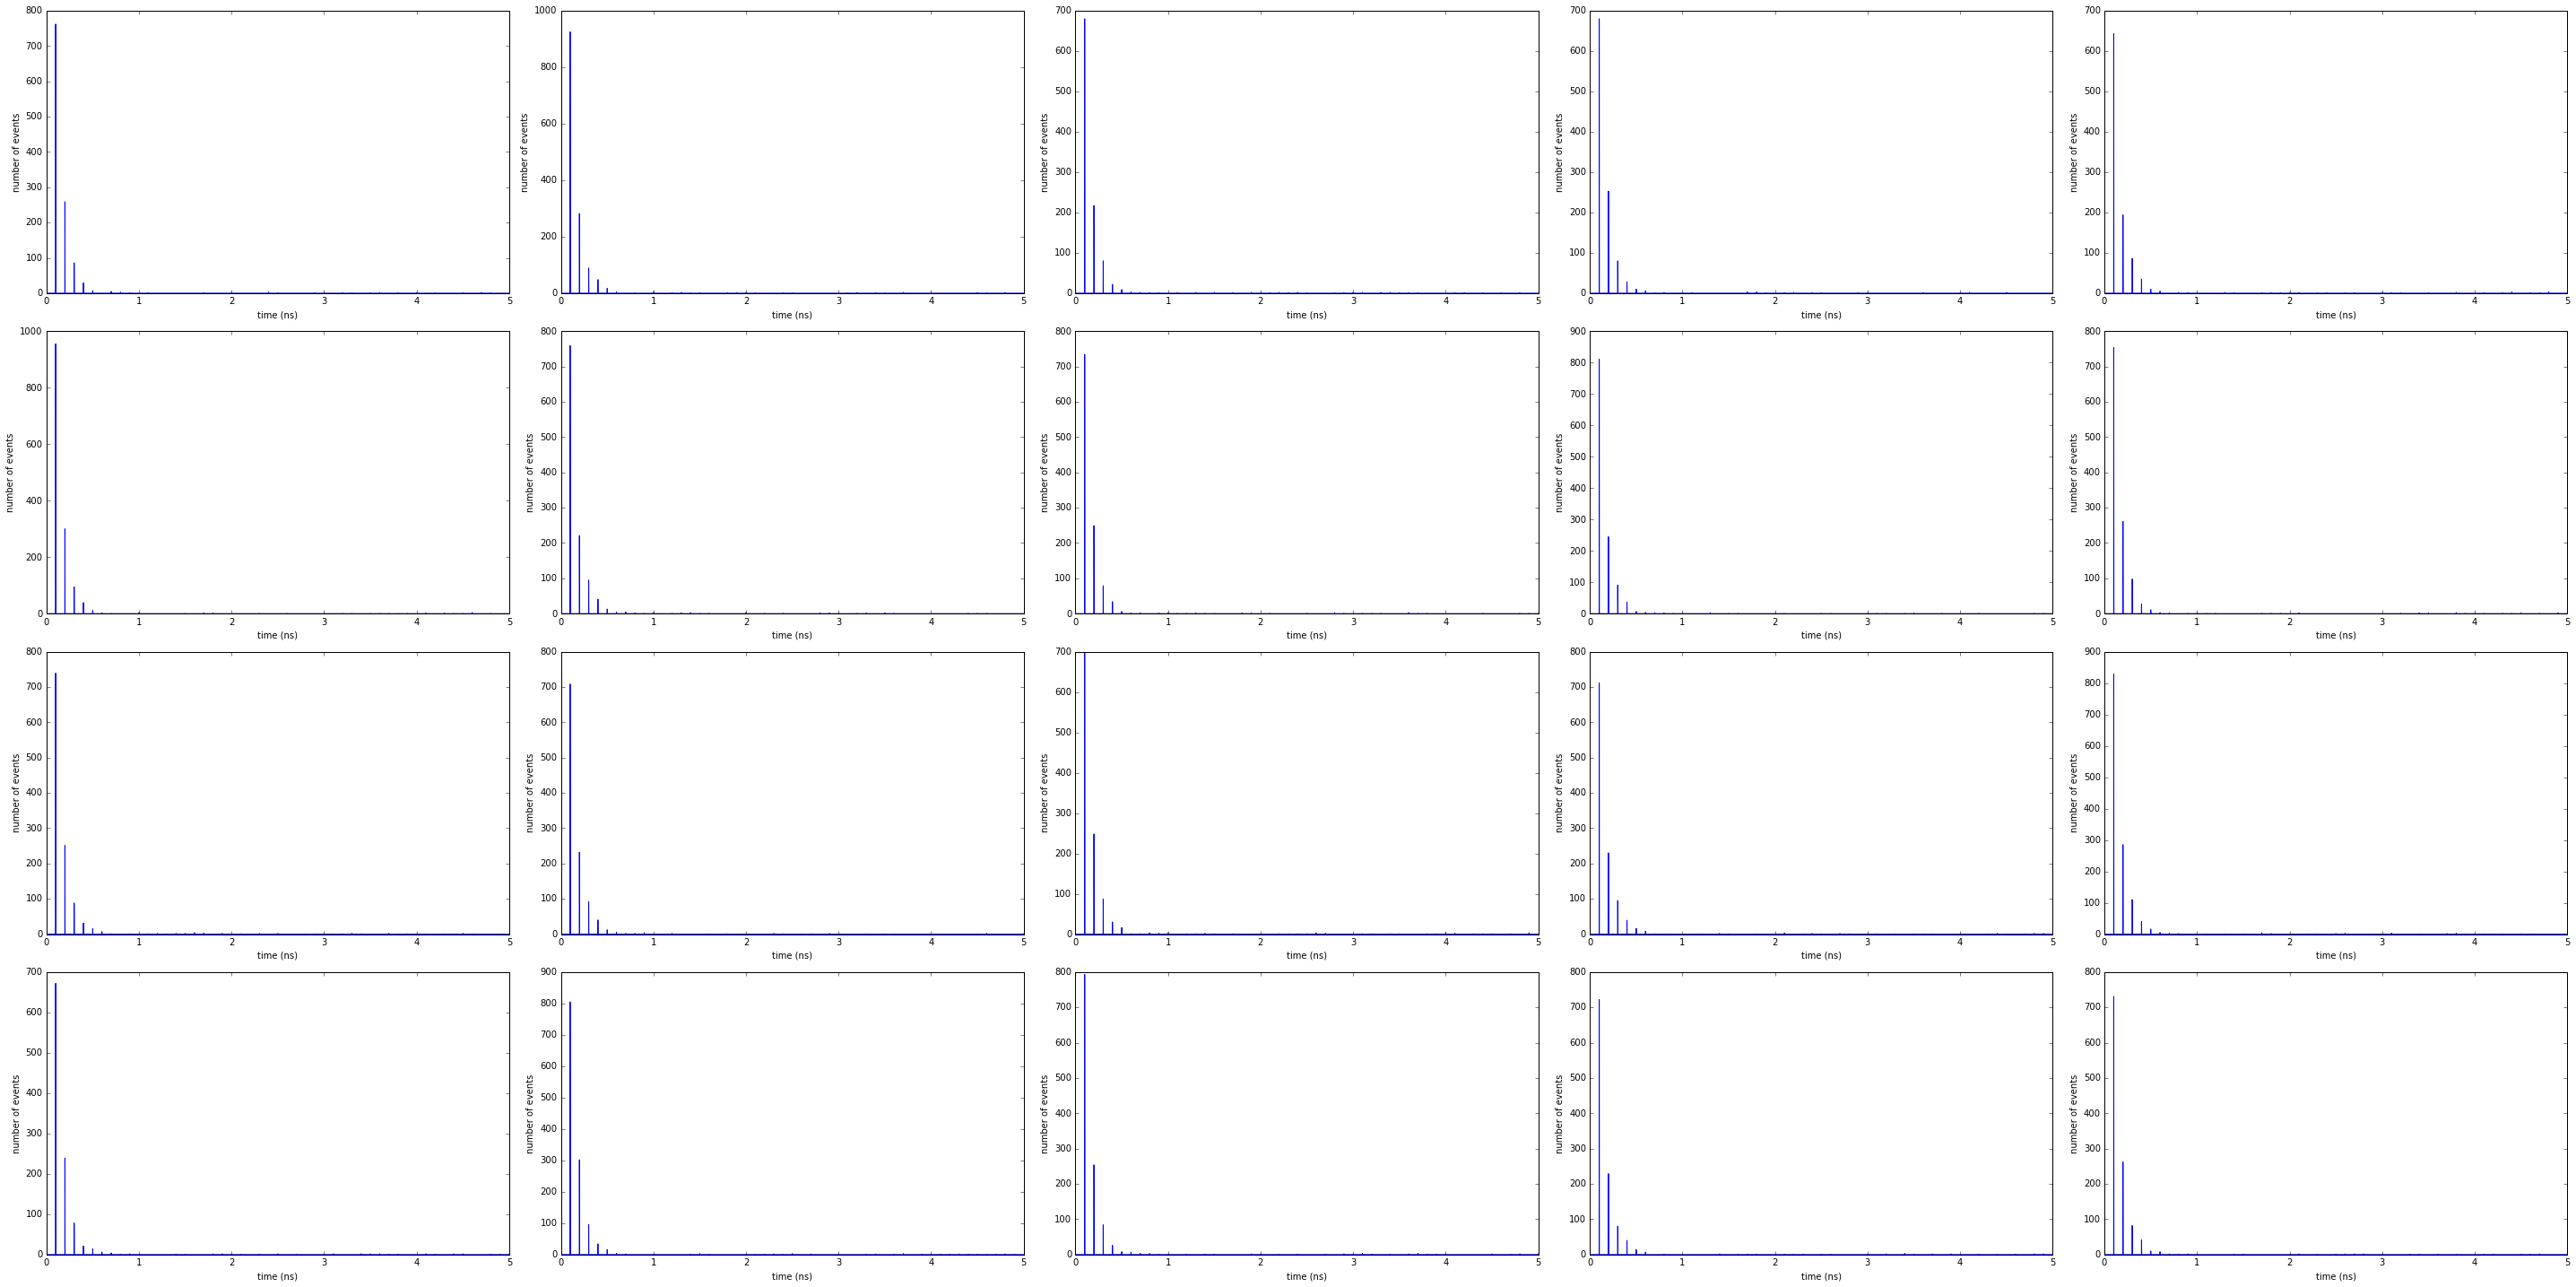

In [43]:
# let's plot dwell time distribution
from matplotlib import pyplot as plt
%matplotlib inline

binding_total = np.load('total_binding_dwell.npy')
unbinding_total = np.load('total_unbinding_dwell.npy')

print "Binding events dwell time distribution"
plt.figure(figsize=(40,20))
for i in range(20):
    binding = binding_total[i]
    print "longest dwell time", max(binding),"ns"
    counts_binding,bins_binding = np.histogram(binding, bins=np.arange(0,max(binding),0.001) )
    bincenters_binding = (bins_binding[0:-1]+bins_binding[1:])/2.0
    plt.subplot(4,5,i+1)
    plt.plot(bincenters_binding, counts_binding)
    plt.xlabel('time (ns)')
    plt.ylabel('number of events')
plt.tight_layout()
plt.savefig('dwell_time_binding.pdf')
plt.show()
plt.close()  

print "Unbinding events dwell time distribution"
plt.figure(figsize=(40,20))    
for i in range(20):
    unbinding = unbinding_total[i]
    print "longest dwell time", max(unbinding),"ns"
    counts_unbinding,bins_unbinding = np.histogram(unbinding, bins=np.arange(0,max(unbinding),0.001) )
    bincenters_unbinding = (bins_unbinding[0:-1]+bins_unbinding[1:])/2.0
    plt.subplot(4,5,i+1)
    plt.plot(bincenters_unbinding, counts_unbinding)
    plt.xlim(0,5)
    plt.xlabel('time (ns)')
    plt.ylabel('number of events')
plt.tight_layout()
plt.savefig('dwell_time_unbinding.pdf')
plt.show()
plt.close()    



In [44]:
# let's compute averaged dwell time for binding and unbinding

binding_total = np.load('total_binding_dwell.npy')
unbinding_total = np.load('total_unbinding_dwell.npy')
reshape_binding = []
reshape_unbinding = []
for i in range(20):
    for j in binding_total[i]:
        reshape_binding.append(j)
    for k in unbinding_total[i]:
        reshape_unbinding.append(k)
print "avg dwell time for binding", np.mean(reshape_binding),'ns', 'std', np.std(reshape_binding)
print "avg dwell time for unbinding", np.mean(reshape_unbinding),'ns', 'std', np.std(reshape_unbinding)


    

avg dwell time for binding 0.53715205804 ns std 0.493180488614
avg dwell time for unbinding 3.89249203645 ns std 12.8456014479
